# Final Project: Overview

# Objective

The objective of this project is for you to demonstrate your mastery of the Machine Learning process
**using Neural Networks**.



## First of all, it is a regression task, which helps predict a continuous quantity(stock return for a continuous period of time). 
### It is not a classification task because classification predicts discrete class labels, which is not fit our project. 

## For regression, the most popular performance measures are R squared and the root mean squared error (RMSE). MSE is highly biased for higher values, so RMSE could be better in terms of reflecting performance when dealing with large error values. RMSE is more useful when lower residual values are preferred.

## For this project, my strategy is to predict future close price, and then convert them to daily return.

<font color='Green'> Model summary: 
    model0 (conv1d+2 layers lstm 8,16); 
    model1 (conv1d+2 layers lstm 16,32); 
    model2 (3 layers lstm); 
    model3 (GRU model)

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import math
import os
import datetime as dt
import seaborn as sns

%matplotlib inline
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Embedding, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten, GRU, Bidirectional


from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, LambdaCallback
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


# First, only use AAPL to predict

In [2]:
# Date Input
TRAIN_PATH = "./data/train"
TEST_PATH = "./data/holdout"
df = pd.read_csv(os.path.join(TRAIN_PATH,"AAPL.csv"))

In [3]:
df #We could see the data start from 2000 to 2016

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume
0,2000-01-03,3.4785,111.938,0.0,1.0,112.5000,101.688,104.8750,133949200.0
1,2000-01-04,3.1852,102.500,0.0,1.0,110.6250,101.188,108.2500,128094400.0
2,2000-01-05,3.2318,104.000,0.0,1.0,110.5630,103.000,103.7500,194580400.0
3,2000-01-06,2.9521,95.000,0.0,1.0,107.0000,95.000,106.1183,191993200.0
4,2000-01-07,3.0920,99.500,0.0,1.0,101.0000,95.500,96.5000,115183600.0
...,...,...,...,...,...,...,...,...,...
4272,2016-12-23,111.3073,116.520,0.0,1.0,116.5255,115.590,115.5900,14249500.0
4273,2016-12-27,112.0142,117.260,0.0,1.0,117.8000,116.490,116.5200,18296900.0
4274,2016-12-28,111.5366,116.760,0.0,1.0,118.0170,116.200,117.5200,20905900.0
4275,2016-12-29,111.5079,116.730,0.0,1.0,117.1094,116.400,116.4500,15039500.0


## EDA

In [4]:
# Draw a correlation map to show Pearson correlation coefficients among features to check if multicollinearity exist.
def corr_map(df):
    var_corr = df.corr()
    mask = np.zeros_like(var_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    f, ax = plt.subplots(figsize=(20, 12))
    sns.set(font_scale=1)
    sns.heatmap(var_corr, mask=mask, cmap=cmap, vmax=1, center=0
               ,square=True, linewidths=.5, cbar_kws={"shrink": .5}
               ,annot=True,annot_kws={'size':12,'weight':'bold', 'color':'red'})
    plt.show()

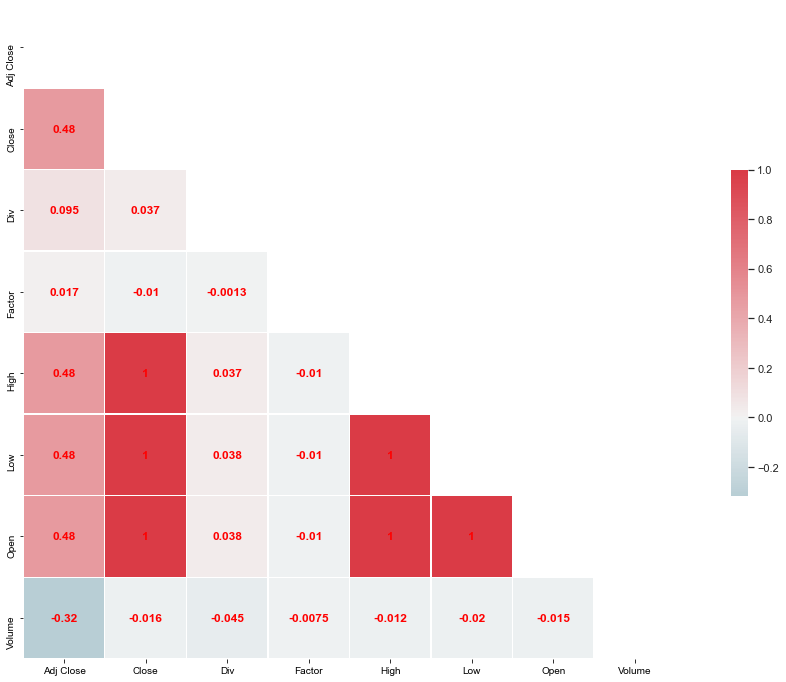

In [5]:
# notice that close price is highly correlated to open,low,high price, therefore I will drop two of them to avoid multicollinearity.
corr_map(df)

In [6]:
#Though it seems data are in order, we need to make sure that data is sorted by date. Because the order of data is important in time series modeling.
df = df.sort_values('Dt') # Make sure data is sorted by date

<AxesSubplot:xlabel='Dt'>

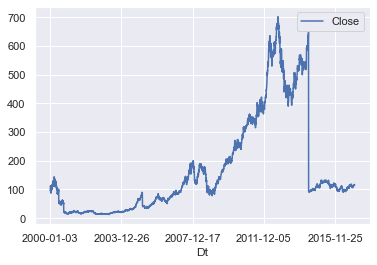

In [7]:
df.plot(x='Dt', y='Close') # Notice there is a jump in close price.

In [8]:
df.info() # See data type for each column, notice there is no missing value.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4277 entries, 0 to 4276
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Dt         4277 non-null   object 
 1   Adj Close  4277 non-null   float64
 2   Close      4277 non-null   float64
 3   Div        4277 non-null   float64
 4   Factor     4277 non-null   float64
 5   High       4277 non-null   float64
 6   Low        4277 non-null   float64
 7   Open       4277 non-null   float64
 8   Volume     4277 non-null   float64
dtypes: float64(8), object(1)
memory usage: 334.1+ KB


In [9]:
df

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume
0,2000-01-03,3.4785,111.938,0.0,1.0,112.5000,101.688,104.8750,133949200.0
1,2000-01-04,3.1852,102.500,0.0,1.0,110.6250,101.188,108.2500,128094400.0
2,2000-01-05,3.2318,104.000,0.0,1.0,110.5630,103.000,103.7500,194580400.0
3,2000-01-06,2.9521,95.000,0.0,1.0,107.0000,95.000,106.1183,191993200.0
4,2000-01-07,3.0920,99.500,0.0,1.0,101.0000,95.500,96.5000,115183600.0
...,...,...,...,...,...,...,...,...,...
4272,2016-12-23,111.3073,116.520,0.0,1.0,116.5255,115.590,115.5900,14249500.0
4273,2016-12-27,112.0142,117.260,0.0,1.0,117.8000,116.490,116.5200,18296900.0
4274,2016-12-28,111.5366,116.760,0.0,1.0,118.0170,116.200,117.5200,20905900.0
4275,2016-12-29,111.5079,116.730,0.0,1.0,117.1094,116.400,116.4500,15039500.0


In [10]:
df.describe()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4.277000e+03
mean,34.065846,170.450354,0.001999,1.001870,172.424040,168.407568,170.528689,1.299660e+08
std,36.698987,173.484604,0.031011,0.094251,174.989551,171.934671,173.604272,9.970883e+07
min,0.815400,13.120000,0.000000,1.000000,13.190000,12.720000,12.990000,9.835000e+06
25%,3.115300,39.759000,0.000000,1.000000,40.260000,39.030000,39.530000,6.363350e+07
50%,16.948300,106.745000,0.000000,1.000000,108.360000,105.200000,106.959000,1.016484e+08
75%,62.413600,222.250000,0.000000,1.000000,224.980000,217.890000,220.010000,1.679636e+08
max,122.771400,702.100000,0.570000,7.000000,705.070000,699.570000,702.410000,1.855410e+09


# <font color ="blue"> Create more features.

<font color='purple'> Create volatility as a New Feature.

In [11]:
df['Volatility'] = np.log((df['Close']+1)).std()

<font color='purple'> Change between High & Low price in the same day as a New Feature.

In [12]:
df['H_L_Change'] = df['High']/df['Low'] - 1

<font color='purple'> Change between Open & Close price in the same day as a New Feature.

In [13]:
# Tried this feature but models predicts better without this feature.
#df['O_C_Change'] = df['Close']/df['Open'] - 1

<font color ='green'> Set data as index and drop highly correlated factors(only save one).

In [14]:
df = df.set_index(['Dt']) #Set date as index
df = df.drop(['High','Low'], axis = 1) # Drop high,low because they are highly correlated with factor 'open'.

In [15]:
# Change order of 'Close' and 'Adj Close' to make following steps easier.
first_col = df.pop(df.columns[0])
df.insert(1, first_col.name, first_col)

In [16]:
# Drip Div and Factor because they does not effect price based on my trading knowledge.
# df = df.drop(['Div','Factor'], axis = 1) 

In [17]:
df

,Close,Adj Close,Div,Factor,Open,Volume,Volatility,H_L_Change
Dt,,,,,,,,
2000-01-03,111.938,3.4785,0.0,1.0,104.8750,133949200.0,1.095429,0.106325
2000-01-04,102.500,3.1852,0.0,1.0,108.2500,128094400.0,1.095429,0.093262
2000-01-05,104.000,3.2318,0.0,1.0,103.7500,194580400.0,1.095429,0.073427
2000-01-06,95.000,2.9521,0.0,1.0,106.1183,191993200.0,1.095429,0.126316
2000-01-07,99.500,3.0920,0.0,1.0,96.5000,115183600.0,1.095429,0.057592
...,...,...,...,...,...,...,...,...
2016-12-23,116.520,111.3073,0.0,1.0,115.5900,14249500.0,1.095429,0.008093
2016-12-27,117.260,112.0142,0.0,1.0,116.5200,18296900.0,1.095429,0.011246
2016-12-28,116.760,111.5366,0.0,1.0,117.5200,20905900.0,1.095429,0.015637


In [18]:
df.isna().any().any() #Check if there are missing values: No missing values.

False

## Split train and test set---80% for train, 20% for test

In [19]:
# Function to split train and test: set first 80% of data to be train set, the last 20% be test set.
def train_test_split(df):
    train_start = 0
    train_end = int(np.floor(0.8*len(df)))
    test_start = train_end
    test_end = len(df)
    train = df[train_start:train_end]
    test = df[test_start:test_end]
    return train, test

In [20]:
train, test = train_test_split(df)

In [21]:
# Data normalization
scaler = MinMaxScaler()

train=scaler.fit_transform(train)
test=scaler.transform(test)

In [22]:
print("train shape:",train.shape, " test shape:",test.shape)

train shape: (3421, 8)  test shape: (856, 8)


In [23]:
# Write a function to split data into X and Y
def window(data, his_num):
    inputs = []
    output = []
    k = len(data) - his_num - 1
    for i in range(k): 
        inputs.append(data[i: i + his_num,1:])
        #inputs.append(data[i: i + his_num,0])
        output.append(data[i + his_num, 0])
        X = np.array(inputs)
        Y = np.array(output)

    return X, Y

In [24]:
# I use past 10 days data to predict the next day return
# Because stock prices do not depend on history too far away. Recent history may shows recent news or activities that could effect stock price. 
X_train, y_train = window(train, 10)
X_test, y_test = window(test, 10)

#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [25]:
y_train

array([0.13181515, 0.13562513, 0.14569363, ..., 0.66232692, 0.65623095,
       0.65583907])

In [26]:
# Split validation set from train, 20% of train is set to be validation set.
valid = X_train.shape[0]*2//10

X_valid = X_train[ :valid]
y_valid = y_train[ :valid]
    
X_train = X_train[valid: ]
y_train = y_train[valid: ]

In [27]:
print(" train set:",
      "\n X_train shape = {a}, y_train.shape = {b}".format(a = np.shape(X_train), b = np.shape(y_train)),
      "\n test set:",
      "\n X_test shape = {c}, y_test.shape: {d}".format(c = np.shape(X_test), d = np.shape(y_test)),
      "\n validation set:",
      "\n X_valid shape = {e}, y_valid.shape: {f}".format(e = np.shape(X_valid), f = np.shape(y_valid)))

 train set: 
 X_train shape = (2728, 10, 7), y_train.shape = (2728,) 
 test set: 
 X_test shape = (845, 10, 7), y_test.shape: (845,) 
 validation set: 
 X_valid shape = (682, 10, 7), y_valid.shape: (682,)


# Baseline Model --> Model 0
### Since predicted return for day t should be a function of data occurring before day t, it's a time series. I'll use LSTM model to predict.
### 1 layers cnn + 2 layer LSTM

In [28]:
def baseModel():
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=5, padding='same', activation='relu'))
    
    model.add(LSTM(8, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(16))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='relu')) #Use relu because close prices are all positive numbers.
  
    es_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=.0005,patience=2,verbose=0,mode='auto',baseline=None,restore_best_weights=True)

    return model

In [29]:
# Train the base model
model0 = baseModel()
# Because it is a regression project explained at the beginning, MSR is used as performance measures.
# After tried SGD and adagrad, i founf adam works best by optimizing the loss in minimum steps, compares to SGD and adagrad.
model0.compile(optimizer="adam", loss="mean_squared_error")  

model0.fit(X_train, y_train, epochs=10, batch_size = 10, shuffle=True, validation_data=(X_valid, y_valid))
model0.evaluate(X_test, y_test)

# PREDICTION
y_train_base = model0.predict(X_train)
y_valid_base = model0.predict(X_valid)
y_test_base = model0.predict(X_test)

Train on 2728 samples, validate on 682 samples
Epoch 1/10
2728/2728 [==============================] - 13s 5ms/sample - loss: 0.0187 - val_loss: 0.0025
Epoch 2/10
2728/2728 [==============================] - 8s 3ms/sample - loss: 0.0032 - val_loss: 0.0023
Epoch 3/10
2728/2728 [==============================] - 9s 3ms/sample - loss: 0.0027 - val_loss: 0.0015
Epoch 4/10
2728/2728 [==============================] - 9s 3ms/sample - loss: 0.0023 - val_loss: 0.0020
Epoch 5/10
2728/2728 [==============================] - 9s 3ms/sample - loss: 0.0021 - val_loss: 0.0021
Epoch 6/10
2728/2728 [==============================] - 9s 3ms/sample - loss: 0.0021 - val_loss: 0.0014
Epoch 7/10
2728/2728 [==============================] - 8s 3ms/sample - loss: 0.0019 - val_loss: 0.0022
Epoch 8/10
2728/2728 [==============================] - 9s 3ms/sample - loss: 0.0017 - val_loss: 0.0024
Epoch 9/10
2728/2728 [==============================] - 9s 3ms/sample - loss: 0.0018 - val_loss: 0.0023
Epoch 10/10
2728

In [30]:
model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              multiple                  576       
_________________________________________________________________
lstm (LSTM)                  multiple                  800       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lstm_1 (LSTM)                multiple                  1600      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  17        
Total params: 2,993
Trainable params: 2,993
Non-trainable params: 0
______________________________________________________

In [31]:
def compare_plot(predict, actual):
    plt.figure(figsize = (15, 6))
    plt.plot(predict,"b",label="predicted")
    plt.plot(actual,"r",label="actual")
    plt.legend()
    plt.show()

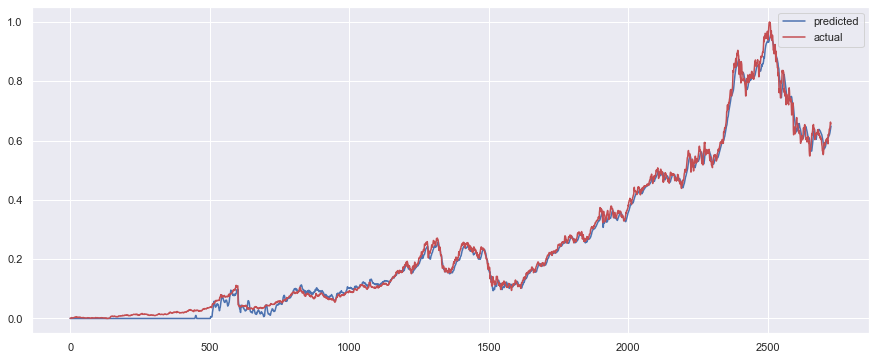

In [32]:
compare_plot(y_train_base,y_train)

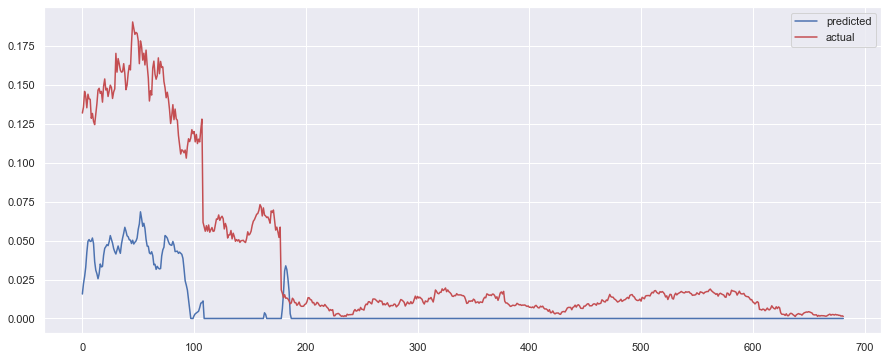

In [33]:
compare_plot(y_valid_base,y_valid)

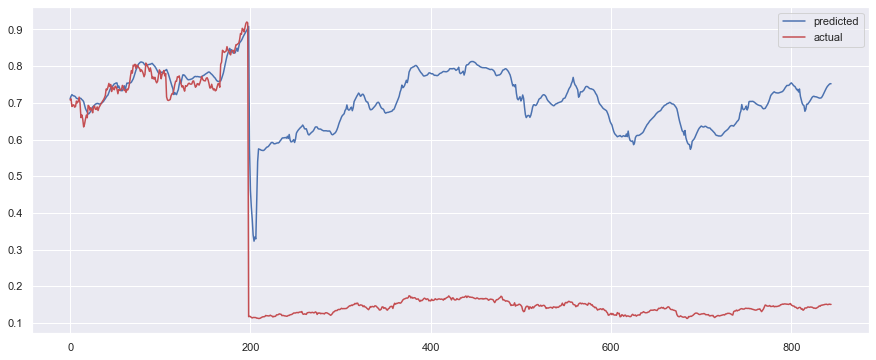

In [34]:
compare_plot(y_test_base,y_test) 

In [35]:
#Calculate RMSE of train and test
mse_train = mean_squared_error(y_train, y_train_base)
print("Train Data MSE = ", mse_train)
rmse_train = mean_squared_error(y_train, y_train_base,squared=False)
print("Train Data RMSE = ", rmse_train)
print("")
mse_test = mean_squared_error(y_test, y_test_base)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_test, y_test_base,squared=False)
print("Test Data RMSE = ", rmse_test)


Train Data MSE =  0.0003103440429684478
Train Data RMSE =  0.01761658431616208

Test Data MSE =  0.23259719424405642
Test Data RMSE =  0.4822833132548299


<font color='red'>In conclusion, we could tell that our basemodel is not that accurate, but it did predict the jump in test set.</font>

# Improve Model --> Model 1
### change filter number from 8,16 to 16,32. 
<font color='green'>Since baseline model does not do very well, I will increase the filter number to see if predict better.</font>


In [36]:
def Model1():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
    
    model.add(LSTM(16, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='relu')) #Use relu because close prices are all positive numbers.
  
    es_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=.0005,patience=2,verbose=0,mode='auto',baseline=None,restore_best_weights=True)

    return model

In [37]:
# Train the base model
model = Model1()
# Because it is a regression project explained at the beginning, MSR is used as performance measures.
# adam works best by optimizing the loss in minimum steps, compares to SGD and adagrad.
model.compile(optimizer="adam", loss="mean_squared_error")  

#model.fit(X_train, y_train, epochs=10, batch_size=10)
model.fit(X_train, y_train, epochs=10, batch_size = 10, shuffle=True, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

# PREDICTION
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

Train on 2728 samples, validate on 682 samples
Epoch 1/10
2728/2728 [==============================] - 15s 6ms/sample - loss: 0.0051 - val_loss: 0.0016
Epoch 2/10
2728/2728 [==============================] - 9s 3ms/sample - loss: 0.0021 - val_loss: 0.0010
Epoch 3/10
2728/2728 [==============================] - 9s 3ms/sample - loss: 0.0018 - val_loss: 9.4399e-04
Epoch 4/10
2728/2728 [==============================] - 9s 3ms/sample - loss: 0.0018 - val_loss: 2.8952e-04
Epoch 5/10
2728/2728 [==============================] - 9s 3ms/sample - loss: 0.0016 - val_loss: 9.1469e-04
Epoch 6/10
2728/2728 [==============================] - 10s 4ms/sample - loss: 0.0015 - val_loss: 7.3173e-04
Epoch 7/10
2728/2728 [==============================] - 10s 4ms/sample - loss: 0.0012 - val_loss: 7.6227e-04
Epoch 8/10
2728/2728 [==============================] - 10s 4ms/sample - loss: 0.0011 - val_loss: 3.0099e-04
Epoch 9/10
2728/2728 [==============================] - 9s 3ms/sample - loss: 9.6432e-04 - va

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            multiple                  1152      
_________________________________________________________________
lstm_2 (LSTM)                multiple                  3136      
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
lstm_3 (LSTM)                multiple                  6272      
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  33        
Total params: 10,593
Trainable params: 10,593
Non-trainable params: 0
__________________________________________________

In [39]:
y_train_pred.shape

(2728, 1)

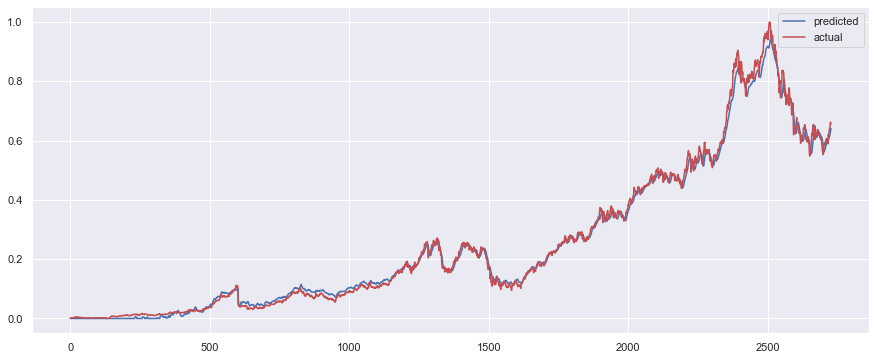

In [40]:
compare_plot(y_train_pred,y_train)

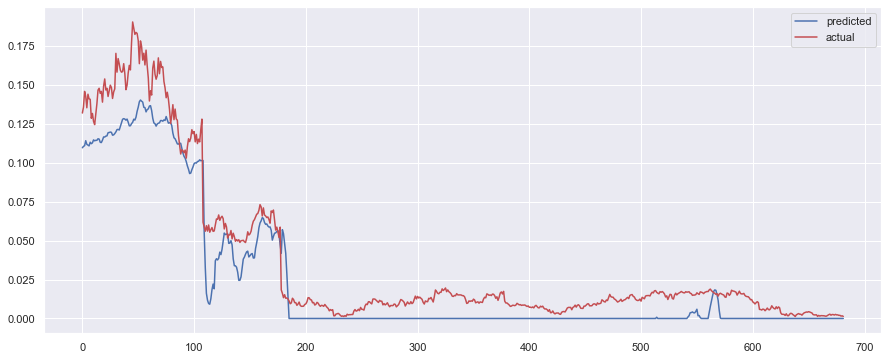

In [41]:
compare_plot(y_valid_pred,y_valid)

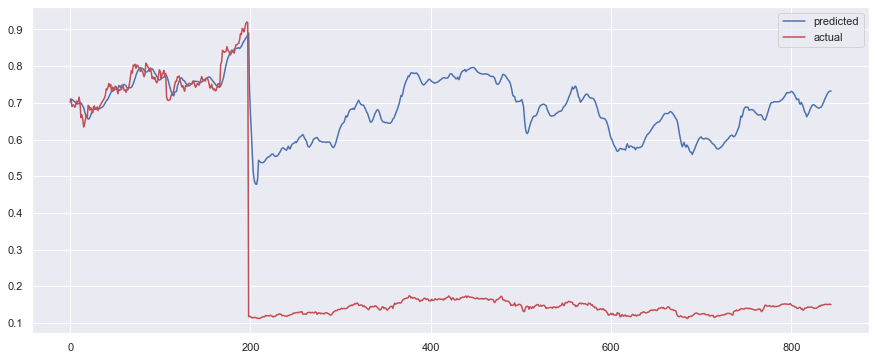

In [42]:
compare_plot(y_test_pred,y_test) #Though it does not very accurate,the model does notice the jump on close price.

### Error Analysis

In [43]:
#Calculate RMSE of train and test
mse_train = mean_squared_error(y_train, y_train_pred)
print("Train Data MSE = ", mse_train)
rmse_train = mean_squared_error(y_train, y_train_pred,squared=False)
print("Train Data RMSE = ", rmse_train)
print("")
mse_test = mean_squared_error(y_test, y_test_pred)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_test, y_test_pred,squared=False)
print("Test Data RMSE = ", rmse_test)


Train Data MSE =  0.0003002784569964956
Train Data RMSE =  0.01732854457236659

Test Data MSE =  0.2146410352533674
Test Data RMSE =  0.46329368143043714


In [44]:
# R^2 shows how close our prediction to the actual value; explained variation measures the discrepancy between a model and actual data. 
# Higher value for both factors show better prediction.
r2 = r2_score(y_test, y_test_pred)
print("R2: ", r2)
exp_var = explained_variance_score(y_test, y_test_pred)
print("Explained Variation: ", exp_var)

R2:  -2.0860967593369835
Explained Variation:  0.2367856218940756


<font color='red'>the test rmse of model1 is less than it is model0, means a larger number of lstm filter cause better prediction <\font>

# Improve model again --> Model 2
## We will add other stocks that may affect AAPL price and use 3 layers of lstm to predict.
<font color = 'green'>In model2, I would add more features, and try to increase number of lstm layer to see if predict better.

In [45]:
# Create a function to read data from other files and sort them in time order.
def read_data(stock):
    df = pd.read_csv(os.path.join(TRAIN_PATH, stock)) 
    df = df.sort_values('Dt')
    df = df.set_index(['Dt'])
    df = df.drop(['Adj Close'], axis = 1)
    return df

In [46]:
# Add stock cisco, ibm, spy, and msft. 
# According to Apple website, cisco and ibm are their business partners. So add them in our model.
# Include spy because AAPL has the highest weighting (7.1%) in the S&P 500 index.
# Include nvda and msft because Nvidia and Microsoft Corporation are technology companies, so does Apple.
cisco = read_data("CSCO.csv")
ibm = read_data("IBM.csv")
spy = read_data("SPY.csv")
#msft = read_data("MSFT.csv") Tried msft but prediction is worse with this stock.
nvda = read_data("NVDA.csv") # Add NVDA

In [47]:
data = df
data['CISCO']=cisco['Close']
data['IBM']=ibm['Close']
data['SPY']=spy['Close']
#data['MSFT']=msft['Close']
data['NVDA']=nvda['Close']
data

,Close,Adj Close,Div,Factor,Open,Volume,Volatility,H_L_Change,CISCO,IBM,SPY,NVDA
Dt,,,,,,,,,,,,
2000-01-03,111.938,3.4785,0.0,1.0,104.8750,133949200.0,1.095429,0.106325,108.063,116.000,145.438,46.813
2000-01-04,102.500,3.1852,0.0,1.0,108.2500,128094400.0,1.095429,0.093262,102.000,112.063,139.750,45.563
2000-01-05,104.000,3.2318,0.0,1.0,103.7500,194580400.0,1.095429,0.073427,101.688,116.000,140.000,44.063
2000-01-06,95.000,2.9521,0.0,1.0,106.1183,191993200.0,1.095429,0.126316,100.000,114.000,137.750,41.188
2000-01-07,99.500,3.0920,0.0,1.0,96.5000,115183600.0,1.095429,0.057592,105.875,113.500,145.750,41.875
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,116.520,111.3073,0.0,1.0,115.5900,14249500.0,1.095429,0.008093,30.530,166.710,225.710,109.780
2016-12-27,117.260,112.0142,0.0,1.0,116.5200,18296900.0,1.095429,0.011246,30.680,167.140,226.270,117.320
2016-12-28,116.760,111.5366,0.0,1.0,117.5200,20905900.0,1.095429,0.015637,30.420,166.190,224.400,109.250


In [48]:
more_train, more_test = train_test_split(data)

more_train=scaler.fit_transform(more_train)
more_test=scaler.transform(more_test)

In [49]:
print("train shape:",more_train.shape, " test shape:",more_test.shape)

train shape: (3421, 12)  test shape: (856, 12)


In [50]:
X_train, y_train = window(more_train, 10)
X_test, y_test = window(more_test, 10)

In [51]:
# Split validation set from train, 20% of train is set to be validation set.
valid = X_train.shape[0]*2//10

X_valid = X_train[ :valid]
y_valid = y_train[ :valid]
    
X_train = X_train[valid: ]
y_train = y_train[valid: ]

In [52]:
print(" train set:",
      "\n X_train shape = {a}, y_train.shape = {b}".format(a = np.shape(X_train), b = np.shape(y_train)),
      "\n test set:",
      "\n X_test shape = {c}, y_test.shape: {d}".format(c = np.shape(X_test), d = np.shape(y_test)),
      "\n validation set:",
      "\n X_valid shape = {e}, y_valid.shape: {f}".format(e = np.shape(X_valid), f = np.shape(y_valid)))

 train set: 
 X_train shape = (2728, 10, 11), y_train.shape = (2728,) 
 test set: 
 X_test shape = (845, 10, 11), y_test.shape: (845,) 
 validation set: 
 X_valid shape = (682, 10, 11), y_valid.shape: (682,)


In [53]:
def Model2():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
    model.add(LSTM(units = 8, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 16, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units = 64, return_sequences = False))
    model.add(Dropout(0.2))
    
    
    
    model.add(Dense(1, activation='relu')) #Use relu because close prices are all positive numbers.
  
    es_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=.0005,patience=2,verbose=0,mode='auto',baseline=None,restore_best_weights=True)

    return model

In [54]:
# Train the base model
model2 = Model2()
model2.compile(optimizer="adam", loss="mean_squared_error")  
model2.fit(X_train, y_train, epochs=10, batch_size = 10, shuffle=True, validation_data=(X_valid, y_valid))
model2.evaluate(X_test, y_test)

# Prediction
y_train_p = model2.predict(X_train)
y_valid_p = model2.predict(X_valid)
y_test_p = model2.predict(X_test)

Train on 2728 samples, validate on 682 samples
Epoch 1/10
2728/2728 [==============================] - 35s 13ms/sample - loss: 0.0084 - val_loss: 9.4860e-04
Epoch 2/10
2728/2728 [==============================] - 24s 9ms/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 3/10
2728/2728 [==============================] - 23s 9ms/sample - loss: 0.0022 - val_loss: 0.0016
Epoch 4/10
2728/2728 [==============================] - 22s 8ms/sample - loss: 0.0018 - val_loss: 0.0017
Epoch 5/10
2728/2728 [==============================] - 23s 8ms/sample - loss: 0.0015 - val_loss: 0.0013
Epoch 6/10
2728/2728 [==============================] - 23s 8ms/sample - loss: 0.0017 - val_loss: 8.4258e-04
Epoch 7/10
2728/2728 [==============================] - 22s 8ms/sample - loss: 0.0017 - val_loss: 0.0010
Epoch 8/10
2728/2728 [==============================] - 23s 8ms/sample - loss: 0.0014 - val_loss: 5.6955e-04
Epoch 9/10
2728/2728 [==============================] - 23s 8ms/sample - loss: 0.0013 - val_loss: 4.

In [55]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            multiple                  1792      
_________________________________________________________________
lstm_4 (LSTM)                multiple                  1312      
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
lstm_5 (LSTM)                multiple                  1600      
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0         
_________________________________________________________________
lstm_6 (LSTM)                multiple                  6272      
_________________________________________________________________
dropout_6 (Dropout)          multiple                 

In [56]:
y_train_p.shape

(2728, 1)

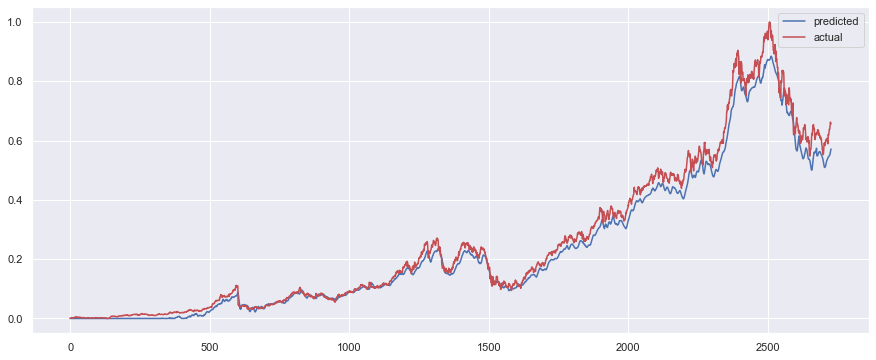

In [57]:
compare_plot(y_train_p,y_train)

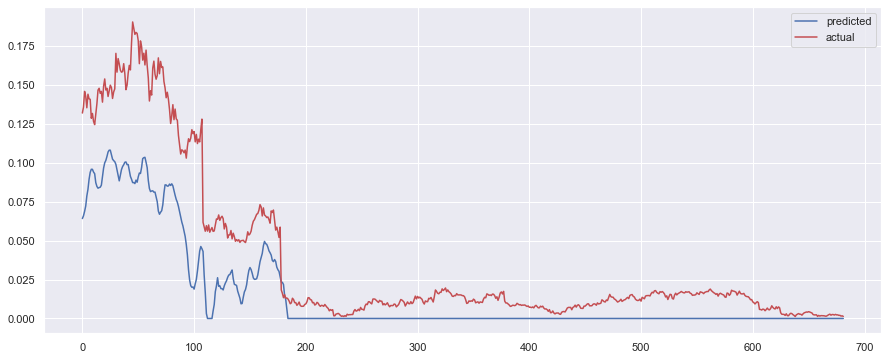

In [58]:
compare_plot(y_valid_p,y_valid)

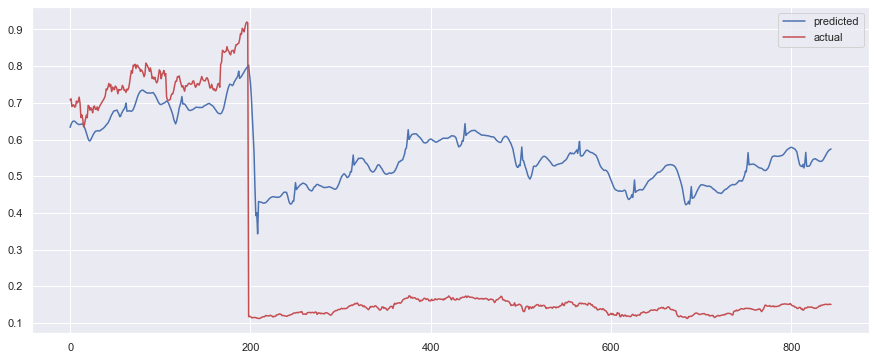

In [59]:
compare_plot(y_test_p,y_test) 

In [60]:
#Calculate RMSE of train and test --- model2 is better than model1, we'll use model2 as final model.
mse_train = mean_squared_error(y_train, y_train_p)
print("Train Data MSE = ", mse_train)
rmse_train = mean_squared_error(y_train, y_train_p,squared=False)
print("Train Data RMSE = ", rmse_train)
print("")
mse_test = mean_squared_error(y_test, y_test_p)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_test, y_test_p,squared=False)
print("Test Data RMSE = ", rmse_test)


Train Data MSE =  0.0012123494675363355
Train Data RMSE =  0.034818809105659196

Test Data MSE =  0.11630311801503819
Test Data RMSE =  0.3410324295650462


<font color = 'red'>In conclusion, 3 layer lstm predicts better than 2 layer lstm model in test set. 

# We also try GRU model --> Model 3

In [61]:
def GRU_Model():
    # three GRU layers and dropout
    model = Sequential()
    model.add(GRU(units = 8, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(GRU(units = 16, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 32, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation = "linear"))
    # call back
    es_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=.0005,patience=2,verbose=0,mode='auto',baseline=None,restore_best_weights=True)

    return model

In [62]:
# Train the GRU model
model3 = GRU_Model()
model3.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")  
model3.fit(X_train, y_train, epochs=20, batch_size = 64, shuffle=False, validation_data=(X_valid, y_valid))
model3.evaluate(X_test, y_test)

# Prediction
y_train_gru = model3.predict(X_train)
y_valid_gru = model3.predict(X_valid)
y_test_gru = model3.predict(X_test)

Train on 2728 samples, validate on 682 samples
Epoch 1/20
2728/2728 [==============================] - 13s 5ms/sample - loss: 0.0093 - val_loss: 0.1265
Epoch 2/20
2728/2728 [==============================] - 3s 947us/sample - loss: 0.0256 - val_loss: 0.1095
Epoch 3/20
2728/2728 [==============================] - 3s 1ms/sample - loss: 0.0249 - val_loss: 0.0181
Epoch 4/20
2728/2728 [==============================] - 3s 1ms/sample - loss: 0.0094 - val_loss: 0.0105
Epoch 5/20
2728/2728 [==============================] - 3s 1ms/sample - loss: 0.0060 - val_loss: 0.0066
Epoch 6/20
2728/2728 [==============================] - 3s 1ms/sample - loss: 0.0045 - val_loss: 0.0324
Epoch 7/20
2728/2728 [==============================] - 3s 1ms/sample - loss: 0.0059 - val_loss: 0.0210
Epoch 8/20
2728/2728 [==============================] - 3s 1ms/sample - loss: 0.0052 - val_loss: 0.0287
Epoch 9/20
2728/2728 [==============================] - 3s 1ms/sample - loss: 0.0053 - val_loss: 0.0426
Epoch 10/20
27

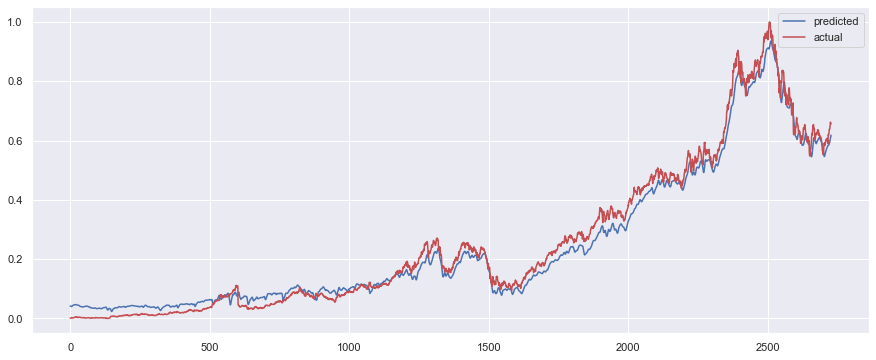

In [63]:
compare_plot(y_train_gru,y_train)

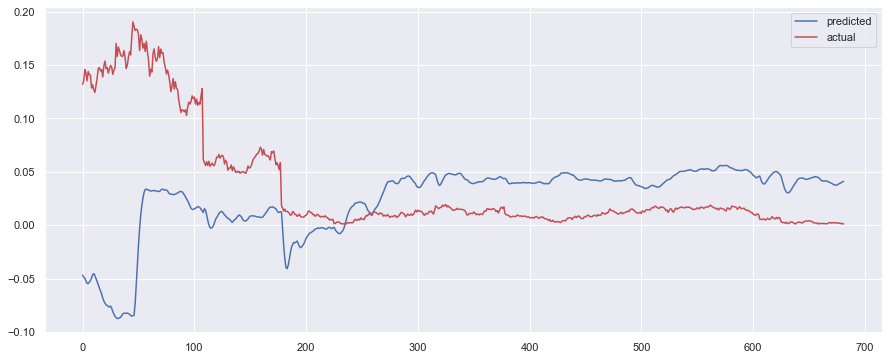

In [64]:
compare_plot(y_valid_gru,y_valid)

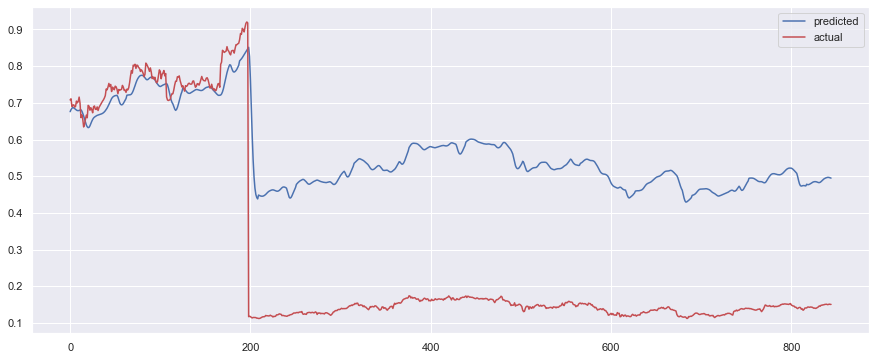

In [65]:
compare_plot(y_test_gru,y_test)

In [66]:
#Calculate RMSE of train and test --- model2 is better than model1, we'll use model2 as final model.
mse_train = mean_squared_error(y_train, y_train_gru)
print("Train Data MSE = ", mse_train)
rmse_train = mean_squared_error(y_train, y_train_gru,squared=False)
print("Train Data RMSE = ", rmse_train)
print("")
mse_test = mean_squared_error(y_test, y_test_gru)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_test, y_test_gru,squared=False)
print("Test Data RMSE = ", rmse_test)

Train Data MSE =  0.0011163951177087606
Train Data RMSE =  0.03341249942325118

Test Data MSE =  0.1072244789710399
Test Data RMSE =  0.32745149101972326


<font color="red"> We could see GRU model does not have a better prediction than lstm model because of it's poor prediction for validation set.

In [67]:
import os
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

#holdout_dir = os.path.join(".", "Data", "holdout")
#predicts = MyModel(holdout_dir, model_path)
def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
 
    # YOUR CODE GOES HERE
    aapl_path = os.path.join(holdout_dir,"AAPL.csv")
    aapl = pd.read_csv(aapl_path)
    
    ids = aapl['Dt']
    
    aapl = aapl.sort_values('Dt')
    # Create New features
    aapl['Volatility'] = np.log((aapl['Close']+1)).std()
    aapl['H_L_Change'] = aapl['High']/aapl['Low'] - 1
    #aapl['O_C_Change'] = aapl['Close']/aapl['Open'] - 1
    
    aapl = aapl.set_index(['Dt']) #Set date as index
    aapl = aapl.drop(['High','Low'], axis = 1)
    # Change order of 'Close' and 'Adj Close' to make following steps easier.
    first_col = aapl.pop(aapl.columns[0])
    aapl.insert(1, first_col.name, first_col)

    
    # Add other stocks
    cisco = read_data("CSCO.csv")
    ibm = read_data("IBM.csv")
    spy = read_data("SPY.csv")
    #msft = read_data("MSFT.csv")
    nvda = read_data("NVDA.csv")
    
    aapl['CISCO']=cisco['Close']
    aapl['IBM']=ibm['Close']
    aapl['SPY']=spy['Close']
    #aapl['MSFT']=msft['Close'] 
    aapl['NVDA']=nvda['Close']
    # scale test
    print(aapl.shape)
    test = scaler.transform(aapl)
    
    X_test, y_test = window(test, 10)
    
    model.compile(optimizer="adam", loss="mean_squared_error") 
    model.fit(X_test, y_test, epochs=10, batch_size=10)
    
    # Since I use close prices as my target to train model, here I convert them into return.
    prediction = model.predict(X_test)
    pred = pd.DataFrame(prediction)
    predictions = np.array(pred[0].pct_change())
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = model2 # CHANGE None to your model !

saveModel(my_model, model_path)

Directory ./final_model already exists, files will be over-written.
Model saved in directory ./final_model; create an archive of this directory and submit with your assignment.


## Evaluate your model on the holdout data directory

**You must run the following cell** from the directory that contains your model file

Here is how we will evaluate your submission
- we will create a directory whose only content is
    - sub-directory `Data`
- we will copy your model file to this directory with the name stored in `model_path`
- we will run the cell in your notebook that should be a copy of the one below
    - it calls procedure `MyModel` with the arguments given below
    - your implementation of `MyModel`
        - must successfully load your model file, *given where **we** have place it as described above*
        - must successfully return one prediction for each example in the holdout directory *given where **we** have placed the holdout directory*

In [68]:
# Here I use train data to make sure MyModel function is work.
holdout_dir = os.path.join(".", "Data", "train")
#holdout_dir = os.path.join(".", "Data", "holdout")
predicts,ids = MyModel(holdout_dir, model_path)

(4277, 12)
Train on 4266 samples
Epoch 1/10
4266/4266 [==============================] - 38s 9ms/sample - loss: 0.0023
Epoch 2/10
4266/4266 [==============================] - 31s 7ms/sample - loss: 0.0016
Epoch 3/10
4266/4266 [==============================] - 33s 8ms/sample - loss: 0.0015
Epoch 4/10
4266/4266 [==============================] - 36s 8ms/sample - loss: 0.0014
Epoch 5/10
4266/4266 [==============================] - 32s 8ms/sample - loss: 0.0013
Epoch 6/10
4266/4266 [==============================] - 31s 7ms/sample - loss: 0.0012
Epoch 7/10
4266/4266 [==============================] - 31s 7ms/sample - loss: 0.0013
Epoch 8/10
4266/4266 [==============================] - 32s 7ms/sample - loss: 0.0012
Epoch 9/10
4266/4266 [==============================] - 31s 7ms/sample - loss: 0.0011
Epoch 10/10
4266/4266 [==============================] - 32s 8ms/sample - loss: 0.0012


In [69]:
predicts

array([        nan,  0.01110375,  0.02120197, ...,  0.00224113,
        0.00198948, -0.00886285], dtype=float32)

In [70]:
ids

0       2000-01-03
1       2000-01-04
2       2000-01-05
3       2000-01-06
4       2000-01-07
           ...    
4272    2016-12-23
4273    2016-12-27
4274    2016-12-28
4275    2016-12-29
4276    2016-12-30
Name: Dt, Length: 4277, dtype: object

In [71]:
print("Done")

Done
